In [0]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd
import datetime 

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve,accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [52]:
#引入googledriver
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1hGuRr0n0a0yTbQKvMXp8SQPa9f2iZWnH'  #雲端硬碟檔案連結碼
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_offline.csv')
#dftrain = pd.read_csv('train_offline.csv')

file_id2 = '1XEq-bMZ1Wq8xDQ21DVqHpyETqNMOiA5K'  #雲端硬碟檔案連結碼
downloaded2 = drive.CreateFile({'id': file_id2})
downloaded2.GetContentFile('test_offline.csv')

#dftest = pd.read_csv('test_offline.csv')
#print(dftrain.shape)
#print(dftest.shape)


In [53]:
# 讀取檔案

# 設定 data_path，讀取檔案
#dir_data = '../ml100marathon-02-01/'
#dftrain = pd.read_csv(os.path.join(dir_data, 'train_offline.csv'))
#dftest = pd.read_csv(os.path.join(dir_data, 'test_offline.csv'))

dftrain = pd.read_csv('train_offline.csv')
dftest = pd.read_csv('test_offline.csv')


#刪除掉dftest資料集中沒有coupon_id的資料
dftest = dftest[~dftest.Coupon_id.isna()]
dftest.reset_index(drop=True, inplace=True)

print(dftrain.shape)
print(dftest.shape)
dftrain.head(20)

(1160742, 7)
(306313, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN


**資料集：dftrain跟dftest的資料要一起處理**

1.   dataA：交易紀錄

*   User_ID
*   Date_received_weekday，weekday1~7：優惠券在星期幾收到
*   Discount_rate_new,discount_A,discount_B：換算Discount_rate=1-b/a
*   Discount_type：標記Discount的類型，要滿a折b=1；還是直接打折=2；沒有discount=0
*   Distance：用戶經常活動地點離商家最近距離



2.   dataB：消費者行為

*   User_ID
*   Coupon_count：領到coupon次數(Coupon_id is not NULL)
*   Coupon_Use_count：使用coupon次數

3.  dataC=dataA+dataB (利用User_ID進行串檔 dataB left Join dataA）

*   target：在15天內使用coupon=1；有優惠券但沒有在15天內使用=0；沒有優惠券=-1



**dataA：交易紀錄**
*   User_ID
*   Date_received_weekday，weekday1~7：優惠券在星期幾收到
*   Discount_rate_new：換算Discount_rate=1-b/a
*   Distance：用戶經常活動地點離商家最近距離


In [54]:
## 計算 Date_received 是星期幾 (weekDay) 
def day_of_week1(row):
    if (np.isnan(row)) or (row==-1):
        return -1
    else:
        return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7
        
dftrain['Date_received_weekday'] = dftrain['Date_received'].apply(day_of_week1)
dftest['Date_received_weekday'] = dftest['Date_received'].apply(day_of_week1)

dftrain.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Date_received_weekday
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,3
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,6
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,5
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,5
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,5
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN,7
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,4
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,6
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,2


In [55]:
## 計算 Date_received 是星期幾 (weekDay)得到 Date_received_weekday 後，把星期展開成weekday1~weekday7，並標示1=是；0=否
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

#get_dummies將星期展開-->one-hot encoding（獨熱編碼）
tmpdf = pd.get_dummies(dftrain['Date_received_weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dftrain[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['Date_received_weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf

dftrain.head(20)

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Date_received_weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,0,0,0,0,0,0,0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,3,0,0,1,0,0,0,0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,6,0,0,0,0,0,1,0
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,5,0,0,0,0,1,0,0
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,5,0,0,0,0,1,0,0
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,5,0,0,0,0,1,0,0
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN,7,0,0,0,0,0,0,1
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,4,0,0,0,1,0,0,0
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,6,0,0,0,0,0,1,0
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,2,0,1,0,0,0,0,0


In [56]:
## 計算Discount_rate=1-b/a，並且記錄discount 的 a,b(滿a元折b元)
def getDiscountType(row):
    if ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):

    df['Discount_rate_new'] = df['Discount_rate'].astype('str').apply(convertRate)
    df['Discount_A'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
    df['Discount_B'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
    df['Discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)
    
    #如果Discount_rate_new欄位是Null，則取代為1.0
    df.loc[df.Discount_rate_new.isna(), "Discount_rate_new"] = 1.0
    return df

dftrain = processData(dftrain)
dftest = processData(dftest)


dftrain.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Date_received_weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,Discount_rate_new,Discount_A,Discount_B,Discount_type
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,0,0,0,0,0,0,0,1.000000,0,0,0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,3,0,0,1,0,0,0,0,0.950000,20,1,1
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,6,0,0,0,0,0,1,0,0.950000,20,1,1
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,5,0,0,0,0,1,0,0,0.900000,200,20,1
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,5,0,0,0,0,1,0,0,0.900000,200,20,1
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,5,0,0,0,0,1,0,0,0.500000,10,5,1
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN,7,0,0,0,0,0,0,1,0.900000,100,10,1
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,4,0,0,0,1,0,0,0,0.850000,200,30,1
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,6,0,0,0,0,0,1,0,0.900000,200,20,1
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,2,0,1,0,0,0,0,0,0.900000,200,20,1


In [57]:
## Distance：用戶經常活動地點離商家最近距離；如果distance=null 取代為99
clean_z = dftrain['Distance'].fillna(99)
dftrain['Distance'] = clean_z

clean_z = dftest['Distance'].fillna(99)
dftest['Distance'] = clean_z
dftrain.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Date_received_weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,Discount_rate_new,Discount_A,Discount_B,Discount_type
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,0,0,0,0,0,0,0,1.000000,0,0,0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,3,0,0,1,0,0,0,0,0.950000,20,1,1
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,6,0,0,0,0,0,1,0,0.950000,20,1,1
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,5,0,0,0,0,1,0,0,0.900000,200,20,1
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,5,0,0,0,0,1,0,0,0.900000,200,20,1
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,5,0,0,0,0,1,0,0,0.500000,10,5,1
6,73611,2099,12034.0,100:10,99.0,20160207.0,NaN,7,0,0,0,0,0,0,1,0.900000,100,10,1
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,4,0,0,0,1,0,0,0,0.850000,200,30,1
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,6,0,0,0,0,0,1,0,0.900000,200,20,1
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,2,0,1,0,0,0,0,0,0.900000,200,20,1


In [58]:
#標示使用Coupon的狀態
"""
1) Date is not null & Coupon_id is null, 則為普通消費日期（沒有優惠券） ==> 0 
2) Date is null & Coupon_id is not null, 則該紀錄為有優惠券但未使用 ==> 0
3) Date is not null & Coupon_id is not null, 則表示優惠券消費日期 ==> 1

"""
def Coupon(row):
    if np.isnan(row['Coupon_id']):
        return 0
    if np.isnan(row['Date']):
        return 0
    else:
        return 1

dftrain["Coupon"] = dftrain.apply(Coupon, axis=1)
dftest["Coupon"] = dftrain.apply(Coupon, axis=1)
dftrain.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Date_received_weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,Discount_rate_new,Discount_A,Discount_B,Discount_type,Coupon
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,0,0,0,0,0,0,0,1.000000,0,0,0,0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,3,0,0,1,0,0,0,0,0.950000,20,1,1,0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,6,0,0,0,0,0,1,0,0.950000,20,1,1,0
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,5,0,0,0,0,1,0,0,0.900000,200,20,1,0
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,5,0,0,0,0,1,0,0,0.900000,200,20,1,0
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,5,0,0,0,0,1,0,0,0.500000,10,5,1,0
6,73611,2099,12034.0,100:10,99.0,20160207.0,NaN,7,0,0,0,0,0,0,1,0.900000,100,10,1,0
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,4,0,0,0,1,0,0,0,0.850000,200,30,1,0
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,6,0,0,0,0,0,1,0,0.900000,200,20,1,0
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,2,0,1,0,0,0,0,0,0.900000,200,20,1,0



**dataB：消費者行為**

*   User_ID
*   Coupon_count：領到coupon次數(Coupon_id is not NULL)
*   Coupon_Use_count：使用coupon次數

In [59]:
#計算消費次數(購買商品時間(Date) is not NULL)
#tmpdf_train_1=dftrain.groupby(['User_id'], as_index=False)['Date'].count()
#tmpdf_train_1.rename(columns={ tmpdf_train_1.columns[1]: 'Date_count'}, inplace=True)
#tmpdf_test_1=dftest.groupby(['User_id'], as_index=False)['Date'].count()
#tmpdf_test_1.rename(columns={ tmpdf_test_1.columns[1]: 'Date_count'}, inplace=True)


#計算領到Coupon的次數(Coupon_id is not NULL)
tmpdf_train_2=dftrain.groupby(['User_id'], as_index=False)['Coupon_id'].count()
tmpdf_train_2.rename(columns={ tmpdf_train_2.columns[1]: 'Coupon_count'}, inplace=True)
tmpdf_test_2=dftest.groupby(['User_id'], as_index=False)['Coupon_id'].count()
tmpdf_test_2.rename(columns={ tmpdf_test_2.columns[1]: 'Coupon_count'}, inplace=True)


#計算使用Coupon的次數
tmpdf_train_3=dftrain.groupby(['User_id'], as_index=False)['Coupon'].sum()
tmpdf_train_3.rename(columns={ tmpdf_train_3.columns[1]: 'Coupon_Use_count'}, inplace=True)
tmpdf_test_3=dftest.groupby(['User_id'], as_index=False)['Coupon'].sum()
tmpdf_test_3.rename(columns={ tmpdf_test_3.columns[1]: 'Coupon_Use_count'}, inplace=True)

##合併欄位，產生新的資料集dataB
#merge_train = pd.merge(tmpdf_train_1,tmpdf_train_2, on='User_id')
#merge_test = pd.merge(tmpdf_test_1,tmpdf_test_2, on='User_id')
userInfo_train = pd.merge(tmpdf_train_2,tmpdf_train_3, on='User_id')
userInfo_test = pd.merge(tmpdf_test_2,tmpdf_test_3, on='User_id')

userInfo_train.head(20)

,User_id,Coupon_count,Coupon_Use_count
0,4,1,0
1,35,4,0
2,36,2,0
3,64,1,0
4,110,3,0
5,144,1,0
6,147,1,0
7,165,2,0
8,173,1,0
9,184,2,1


In [60]:
userInfo_test.head()

,User_id,Coupon_count,Coupon_Use_count
0,4,1,0
1,165,1,0
2,166,1,0
3,215,1,0
4,236,1,0


**dataC=dataA+dataB (利用User_ID進行串檔 dataB left Join dataA）**
*   target：在15天內使用coupon=1；有優惠券但沒有在15天內使用=0；沒有優惠券=-1

In [0]:
#合併資料集，產生新的資料集dftrain_2,dftest_2
dftrain_2=pd.merge(dftrain,userInfo_train, on='User_id',how='left')
dftest_2=pd.merge(dftest,userInfo_test, on='User_id',how='left')

In [62]:
# 目標是要預測用戶在2016年6月領取優惠券後15天以內的使用情況。
# 計算拿到消費券(Date_received	)到使用消費券購買商品的時間(Date)進行 Target的標記
"""
根據「優惠券取得時間(Date_received)」跟「購買商品時間(Date)」標記Target：
1) Date_received is null or Date is null, （沒有優惠券） ==> -1 (Rosa：應該可以忽略這一組資料）
2) Date is null & Date_received is not null, 則該紀錄為有優惠券但未使用 ==> 0
3) Date is not null & Date_received is not null & Date-Date_received>15, 則表示有使用優惠券但>15天 ==> 0
4) Date is not null & Date_received is not null & Date-Date_received<=15, 則表示有使用優惠券，且在15天內使用 ==> 1

"""
def Target(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        # 計算拿到消費券(Date_received	)到使用消費券購買商品的時間(Date)= Date - Date_received
        useDate = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if useDate <= pd.Timedelta(15, 'D'):
            return 1
    return 0
  

dftrain_2["Target"] = dftrain_2.apply(Target, axis=1)
dftrain_2["Target"].value_counts()

dftrain_2.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Date_received_weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,Discount_rate_new,Discount_A,Discount_B,Discount_type,Coupon,Coupon_count,Coupon_Use_count,Target
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,0,0,0,0,0,0,0,1.000000,0,0,0,0,2,0,-1
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,3,0,0,1,0,0,0,0,0.950000,20,1,1,0,2,0,0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,6,0,0,0,0,0,1,0,0.950000,20,1,1,0,2,0,0
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,5,0,0,0,0,1,0,0,0.900000,200,20,1,0,1,0,0
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,5,0,0,0,0,1,0,0,0.900000,200,20,1,0,1,0,0
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,5,0,0,0,0,1,0,0,0.500000,10,5,1,0,1,0,0
6,73611,2099,12034.0,100:10,99.0,20160207.0,NaN,7,0,0,0,0,0,0,1,0.900000,100,10,1,0,1,0,0
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,4,0,0,0,1,0,0,0,0.850000,200,30,1,0,1,0,0
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,6,0,0,0,0,0,1,0,0.900000,200,20,1,0,1,0,0
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,2,0,1,0,0,0,0,0,0.900000,200,20,1,0,1,0,0


In [63]:
dftest_2.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date_received_weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,Discount_rate_new,Discount_A,Discount_B,Discount_type,Coupon,Coupon_count,Coupon_Use_count
0,1439408,4663,11002.0,150:20,1.0,20160528.0,6,0,0,0,0,0,1,0,0.866667,150,20,1,0,3,0
1,1439408,2632,8591.0,20:1,0.0,20160613.0,1,1,0,0,0,0,0,0,0.950000,20,1,1,0,3,0
2,1439408,2632,8591.0,20:1,0.0,20160516.0,1,1,0,0,0,0,0,0,0.950000,20,1,1,0,3,0
3,2029232,450,1532.0,30:5,0.0,20160530.0,1,1,0,0,0,0,0,0,0.833333,30,5,1,0,2,0
4,2029232,6459,12737.0,20:1,0.0,20160519.0,4,0,0,0,1,0,0,0,0.950000,20,1,1,0,2,0
5,2747744,6901,1097.0,50:10,99.0,20160606.0,1,1,0,0,0,0,0,0,0.800000,50,10,1,0,1,0
6,196342,1579,10698.0,20:1,1.0,20160606.0,1,1,0,0,0,0,0,0,0.950000,20,1,1,0,1,0
7,253750,6901,2366.0,30:5,0.0,20160518.0,3,0,0,1,0,0,0,0,0.833333,30,5,1,0,1,0
8,343660,4663,11002.0,150:20,99.0,20160528.0,6,0,0,0,0,0,1,0,0.866667,150,20,1,0,1,0
9,1113008,3621,2705.0,20:5,0.0,20160524.0,2,0,1,0,0,0,0,0,0.750000,20,5,1,0,4,0


In [64]:
# 檢查資料是否有遺漏值
print(np.any(np.isnan(dftrain_2['Target'])))


False


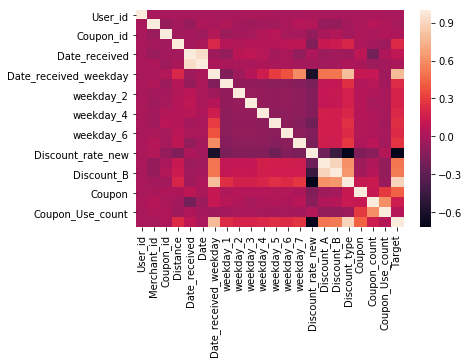

In [65]:
# 計算dftrain_2整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = dftrain_2.corr()
sns.heatmap(corr)
plt.show()

In [66]:
dftrain_2.dtypes

User_id                    int64
Merchant_id                int64
Coupon_id                float64
Discount_rate             object
Distance                 float64
Date_received            float64
Date                     float64
Date_received_weekday      int64
weekday_1                  uint8
weekday_2                  uint8
weekday_3                  uint8
weekday_4                  uint8
weekday_5                  uint8
weekday_6                  uint8
weekday_7                  uint8
Discount_rate_new        float64
Discount_A                 int64
Discount_B                 int64
Discount_type              int64
Coupon                     int64
Coupon_count               int64
Coupon_Use_count           int64
Target                     int64
dtype: object

In [67]:
# 特徵取相異值 (nunique)
dftrain_2.nunique()

User_id                  433113
Merchant_id                6985
Coupon_id                  4483
Discount_rate                45
Distance                     12
Date_received               121
Date                        176
Date_received_weekday         8
weekday_1                     2
weekday_2                     2
weekday_3                     2
weekday_4                     2
weekday_5                     2
weekday_6                     2
weekday_7                     2
Discount_rate_new            20
Discount_A                   10
Discount_B                    8
Discount_type                 2
Coupon                        2
Coupon_count                 51
Coupon_Use_count             37
Target                        3
dtype: int64

**建立模型**

*   標記test跟valid資料
*   選取要建模的指標



In [72]:
dftrain_3=dftrain_2

## 標記test跟valid資料，因為test data的Date_received是45天的資料，所以test跟valid也以此劃分
def split_train_valid(row, date_cut="20160416"):
    is_train = True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False
    return is_train

#target不包含-1的群組(沒有領到coupon)
df = dftrain_3[dftrain_3['Target'] != -1].copy()
df["is_train"] = df["Date_received"].apply(split_train_valid)
train = df[df["is_train"]]
valid = df[~df["is_train"]]
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
print("Train size: {}, #target=1: {}".format(len(train), train["Target"].sum()))
print("Valid size: {}, #target=1: {}".format(len(valid), valid["Target"].sum()))

Train size: 667753, #target=1: 32472
Valid size: 79216, #target=1: 3832


In [73]:
train.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Date_received_weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,Discount_rate_new,Discount_A,Discount_B,Discount_type,Coupon,Coupon_count,Coupon_Use_count,Target,is_train
0,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,3,0,0,1,0,0,0,0,0.95,20,1,1,0,2,0,0,True
1,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,6,0,0,0,0,0,1,0,0.95,20,1,1,0,2,0,0,True
2,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,5,0,0,0,0,1,0,0,0.90,200,20,1,0,1,0,0,True
3,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,5,0,0,0,0,1,0,0,0.50,10,5,1,0,1,0,0,True
4,73611,2099,12034.0,100:10,99.0,20160207.0,NaN,7,0,0,0,0,0,0,1,0.90,100,10,1,0,1,0,0,True


In [231]:
## 選取要建模的指標
original_feature = ['Distance','Discount_rate_new','Discount_A','Discount_B','Discount_type',
                    'Coupon_count','Coupon_Use_count'] + weekdaycols
print("指標數量:",len(original_feature))
print("指標:",original_feature)

指標數量: 14
指標: ['Distance', 'Discount_rate_new', 'Discount_A', 'Discount_B', 'Discount_type', 'Coupon_count', 'Coupon_Use_count', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [224]:
## 選取要建模的指標
original_feature_2 = ['Distance','Discount_rate_new','Discount_A','Discount_B','Discount_type',
                    'Coupon_count','Coupon_Use_count','Date_received_weekday','User_id','Merchant_id'] + weekdaycols
print("指標數量:",len(original_feature_2))
print("指標:",original_feature_2)

指標數量: 17
指標: ['Distance', 'Discount_rate_new', 'Discount_A', 'Discount_B', 'Discount_type', 'Coupon_count', 'Coupon_Use_count', 'Date_received_weekday', 'User_id', 'Merchant_id', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [0]:
#使用網格搜索確定要建立的基學習器個數
#clf = GridSearchCV(RandomForestClassifier(max_features='log2'),param_grid=({'n_estimators':range(499,1000,10)}),cv=100)
#clf.fit(train[predictors],train['Target'])
#print(clf.best_params_)
#再使用網格搜索來確定決策樹的參數
#clf2 = GridSearchCV(RandomForestClassifier(n_estimators=500),param_grid=({'max_depth':range(1,10)}))
#clf2.fit(train[predictors],train['Target'])
#print(clf2.best_params_)

In [0]:
predictors = original_feature

def check_model(data, predictors,modelType):
    if modelType=='1':
      # linear_model.LogisticRegression()
      grid_search= linear_model.LogisticRegression()
    elif modelType=='2':
      # DecisionTreeClassifier()
      grid_search = DecisionTreeClassifier(splitter='random', max_depth=4,min_samples_split=10,min_samples_leaf=5)
    elif modelType=='3':
      # RandomForestClassifier()https://www.itread01.com/content/1521194172.html
      grid_search = RandomForestClassifier(n_estimators=500)
    else:
      # GradientBoostingClassifier()http://d0evi1.com/sklearn/gbdt_param/
      grid_search = GradientBoostingClassifier(learning_rate=0.005, n_estimators=500,max_depth=4)
    
    
    grid_search = grid_search.fit(data[predictors],data['Target'])
    return grid_search

In [83]:
#model_1
model_1= check_model(train, predictors,'1')
y_valid_pred = model_1.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]
auc_score = roc_auc_score(y_true=valid.Target, y_score=y_valid_pred[:,1])
acc = accuracy_score(y_true=valid.Target, y_pred=y_valid_pred.argmax(axis=1))
print("1:LogisticRegression Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

#model_2
model_2= check_model(train, predictors,'2')
y_valid_pred = model_2.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]
auc_score = roc_auc_score(y_true=valid.Target, y_score=y_valid_pred[:,1])
acc = accuracy_score(y_true=valid.Target, y_pred=y_valid_pred.argmax(axis=1))
print("2:DecisionTreeClassifier Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

#model_3
model_3= check_model(train, predictors,'3')
y_valid_pred = model_3.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]
auc_score = roc_auc_score(y_true=valid.Target, y_score=y_valid_pred[:,1])
acc = accuracy_score(y_true=valid.Target, y_pred=y_valid_pred.argmax(axis=1))
print("3:RandomForestClassifier Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

#model_4
model_4= check_model(train, predictors,'4')
y_valid_pred = model_4.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]
auc_score = roc_auc_score(y_true=valid.Target, y_score=y_valid_pred[:,1])
acc = accuracy_score(y_true=valid.Target, y_pred=y_valid_pred.argmax(axis=1))
print("4:GradientBoostingClassifier Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1:LogisticRegression Validation AUC: 0.949, Accuracy: 0.960
2:DecisionTreeClassifier Validation AUC: 0.904, Accuracy: 0.964


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


3:RandomForestClassifier Validation AUC: 0.960, Accuracy: 0.963
4:GradientBoostingClassifier Validation AUC: 0.985, Accuracy: 0.969


根據模型測試的結果：

*   1:LogisticRegression Validation AUC: 0.949, Accuracy: 0.960
*   2:DecisionTreeClassifier Validation AUC: 0.904, Accuracy: 0.964
*   3:RandomForestClassifier Validation AUC: 0.960, Accuracy: 0.963
*   4:GradientBoostingClassifier Validation AUC: 0.985, Accuracy: 0.967

所以選擇梯度提升機 (Gradient Boosting Machine) 進行這次建模的Model

In [235]:
model_3= check_model(train, predictors,'3')
y_valid_pred = model_3.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]
auc_score = roc_auc_score(y_true=valid.Target, y_score=y_valid_pred[:,1])
acc = accuracy_score(y_true=valid.Target, y_pred=y_valid_pred.argmax(axis=1))
print("3:RandomForestClassifier Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))
model=model_3

3:RandomForestClassifier Validation AUC: 0.977, Accuracy: 0.964


In [236]:
targetset = dftest_2.copy()
print(targetset.shape)
targetset = targetset[~targetset.Coupon_id.isna()]
targetset.reset_index(drop=True, inplace=True)
testset = targetset[predictors].copy()

y_test_pred = model.predict_proba(testset[predictors])
test1 = testset.copy()
test1['pred_prob'] = y_test_pred[:, 1]
print(test1.shape)
test1.head(20)

(306313, 21)
(306313, 15)


,Distance,Discount_rate_new,Discount_A,Discount_B,Discount_type,Coupon_count,Coupon_Use_count,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,pred_prob
0,1.0,0.866667,150,20,1,3,0,0,0,0,0,0,1,0,0.000000
1,0.0,0.950000,20,1,1,3,0,1,0,0,0,0,0,0,0.000000
2,0.0,0.950000,20,1,1,3,0,1,0,0,0,0,0,0,0.000000
3,0.0,0.833333,30,5,1,2,0,1,0,0,0,0,0,0,0.000000
4,0.0,0.950000,20,1,1,2,0,0,0,0,1,0,0,0,0.000000
5,99.0,0.800000,50,10,1,1,0,1,0,0,0,0,0,0,0.000000
6,1.0,0.950000,20,1,1,1,0,1,0,0,0,0,0,0,0.000000
7,0.0,0.833333,30,5,1,1,0,0,0,1,0,0,0,0,0.000000
8,99.0,0.866667,150,20,1,1,0,0,0,0,0,0,1,0,0.000000
9,0.0,0.750000,20,5,1,4,0,0,1,0,0,0,0,0,0.000000


In [237]:
output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], test1["pred_prob"]), axis=1)
print(output.shape)

output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)

(306313, 4)


In [238]:
out = output.groupby("uid", as_index=False).mean()
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
out.to_csv('output_rosa_0616_20.csv', header=["uid", "label"], index=False) 
out.head()

,uid,label
0,1000020_2705_20160519,0.0
1,1000020_8192_20160513,0.0
2,1000065_1455_20160527,0.0
3,1000085_8067_20160513,0.0
4,1000086_2418_20160613,0.0


目前分數最好的model：RandomForestClassifier(n_estimators=500, max_depth=4)
